In [1]:
!pip install transformers datasets evaluate rouge_score

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.9 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=31b6e0e17ffabceb331bce6e728e17b948139c7950aa3296825faf3a2d053307
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
from datasets import load_dataset, DatasetDict
from transformers import DataCollatorForSeq2Seq
from transformers import AutoTokenizer
from transformers import create_optimizer, AdamWeightDecay
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import tarfile

In [3]:
!pip install gdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
!gdown --id 1kO8drH_2JwEcTlfQqEj40ct3_DUH5wcf

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kO8drH_2JwEcTlfQqEj40ct3_DUH5wcf
From (redirected): https://drive.google.com/uc?id=1kO8drH_2JwEcTlfQqEj40ct3_DUH5wcf&confirm=t&uuid=98ebe976-9169-4cb0-bd72-3f8d1aa1e883
To: /kaggle/working/Copy of liputan6_data.tar.gz
100%|████████████████████████████████████████| 165M/165M [00:05<00:00, 27.7MB/s]


In [5]:
import tarfile
file_path = "./Copy of liputan6_data.tar.gz"
tar = tarfile.open(file_path, "r:gz")
tar.extractall()
tar.close()
print("File extracted successfully!")

File extracted successfully!


In [6]:
# Load the dataset
data = load_dataset("id_liputan6", 'canonical', data_dir="./liputan6_data", trust_remote_code=True)

id_liputan6.py:   0%|          | 0.00/6.73k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10972 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10972 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/193883 [00:00<?, ? examples/s]

In [7]:
data = DatasetDict({
    'train': data['train'].select(range(10000)),
    'validation': data['validation'].select(range(500)),
    'test': data['test'].select(range(500))
})

In [ ]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get the token from the environment variables
token = os.getenv('KAGGLE_TOKEN')

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, token=token)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [9]:
def tokenize_function(examples):
    inputs = ["summarize: " + doc for doc in examples["clean_article"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length", return_tensors="pt")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["clean_summary"], max_length=128, truncation=True, padding="max_length", return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [10]:
tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [11]:
class CustomT5(T5ForConditionalGeneration):
    def __init__(self, config):
        super().__init__(config)
        self.custom_lstm = nn.LSTM(config.d_model, config.d_model, batch_first=True)

    def forward(self, input_ids=None, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None, **kwargs):
        encoder_output = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True, **kwargs)
        lstm_output, _ = self.custom_lstm(encoder_output.last_hidden_state)

        if decoder_input_ids is None:
             decoder_input_ids = self.prepare_decoder_input_ids_from_labels(labels)

        # Perbaikan: Gunakan super().forward() dan return loss
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,  # Pastikan labels diteruskan!
            **kwargs
        )
        return outputs

In [12]:
model = CustomT5.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of CustomT5 were not initialized from the model checkpoint at google-t5/t5-small and are newly initialized: ['custom_lstm.bias_hh_l0', 'custom_lstm.bias_ih_l0', 'custom_lstm.weight_hh_l0', 'custom_lstm.weight_ih_l0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [13]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  
    save_strategy="epoch",     
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=8,
    learning_rate=2e-5,
    num_train_epochs=50, # Training selama 50 epoch
    weight_decay=0.01,
    save_total_limit=3,
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_strategy="epoch", 
    report_to="none", 
    metric_for_best_model = "eval_loss", 
    greater_is_better=False 
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer
)

In [15]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss
0,2.526500,1.290604
1,1.445200,1.188883
2,1.342500,1.159574
3,1.297700,1.140985
4,1.269500,1.131907
5,1.250300,1.119742
6,1.233600,1.110014
8,1.207200,1.096796
9,1.195300,1.086876
10,1.185100,1.081590


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


In [16]:
model.save_pretrained("./summarization_model")
tokenizer.save_pretrained("./summarization_model")

('./summarization_model/tokenizer_config.json',
 './summarization_model/special_tokens_map.json',
 './summarization_model/spiece.model',
 './summarization_model/added_tokens.json')

In [17]:
!zip -r summarization_model.zip /kaggle/working/summarization_model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/summarization_model/ (stored 0%)
  adding: kaggle/working/summarization_model/generation_config.json (deflated 29%)
  adding: kaggle/working/summarization_model/tokenizer_config.json (deflated 94%)
  adding: kaggle/working/summarization_model/model.safetensors (deflated 14%)
  adding: kaggle/working/summarization_model/config.json (deflated 62%)
  adding: kaggle/working/summarization_model/added_tokens.json (deflated 83%)
  adding: kaggle/working/summarization_model/spiece.model (deflated 48%)
  adding: kaggle/working/summarization_model/special_tokens_map.json (deflated 85%)


In [18]:
from IPython.display import FileLink
FileLink(r'summarization_model.zip')

/kaggle/working/summarization_model.zip

KeyError: 'eval_loss_epoch_1'.  Metrics yang tersedia: dict_keys(['train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss', 'epoch'])
Epoch yang hilang data evaluasinya: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


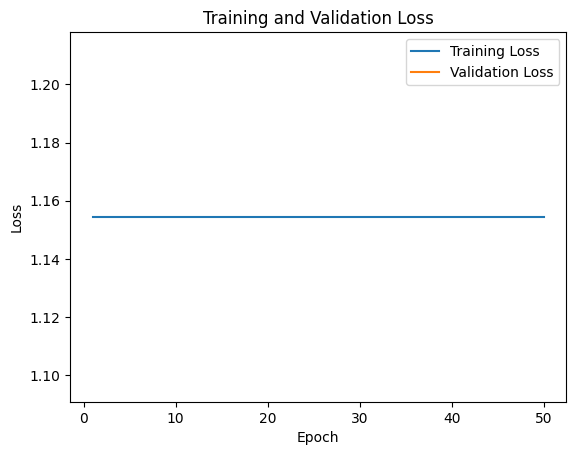

In [19]:
metrics = train_result.metrics
train_loss = metrics["train_loss"]

# Gunakan try-except dan logging untuk menangani KeyError
try:
    validation_loss = [metrics[f"eval_loss_epoch_{i+1}"] for i in range(int(training_args.num_train_epochs))]
except KeyError as e:
    print(f"KeyError: {e}.  Metrics yang tersedia: {metrics.keys()}")
    #  Identifikasi epoch yang hilang
    missing_epochs = []
    for i in range(int(training_args.num_train_epochs)):
        if f"eval_loss_epoch_{i+1}" not in metrics:
            missing_epochs.append(i+1)
    print(f"Epoch yang hilang data evaluasinya: {missing_epochs}")

    #  Jika ada epoch yang hilang, Anda bisa:
    #  1. Mengisi dengan NaN atau nilai lain
    #  2. Menghentikan proses dan menyelidiki masalahnya
    #  3. Melanjutkan dengan epoch yang ada (tidak ideal)


    # Contoh: Mengisi nilai yang hilang dengan NaN
    validation_loss = []
    for i in range(int(training_args.num_train_epochs)):
         if f"eval_loss_epoch_{i+1}" in metrics:
             validation_loss.append(metrics[f"eval_loss_epoch_{i+1}"])
         else:
             validation_loss.append(float('nan'))  # Atau nilai lain yang sesuai


# Plotting (pastikan panjang data konsisten)

epochs = range(1, int(training_args.num_train_epochs) + 1)

plt.plot(epochs, [train_loss] * len(epochs), label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()